# divide observations into watermasses based on location

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
len(obs)

3464571

In [4]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
len(obs)

1931750

In [6]:
# depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
len(obs)

1827315

In [8]:
# lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [9]:
len(obs)

1738431

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

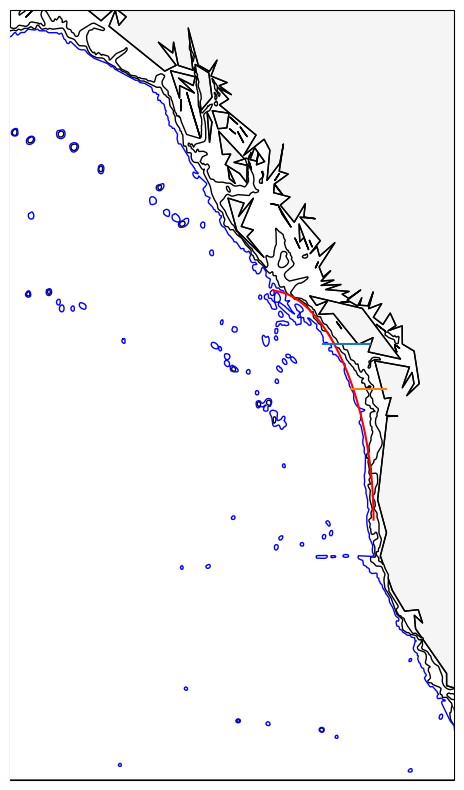

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))


# offshore cuttoff 
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [11]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("./ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.unary_union)

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [12]:
# can we do the same for data between the 200 m and 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("./ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data
# obs_200 = obs_200.to_crs(contour_200m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.unary_union)

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

In [13]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

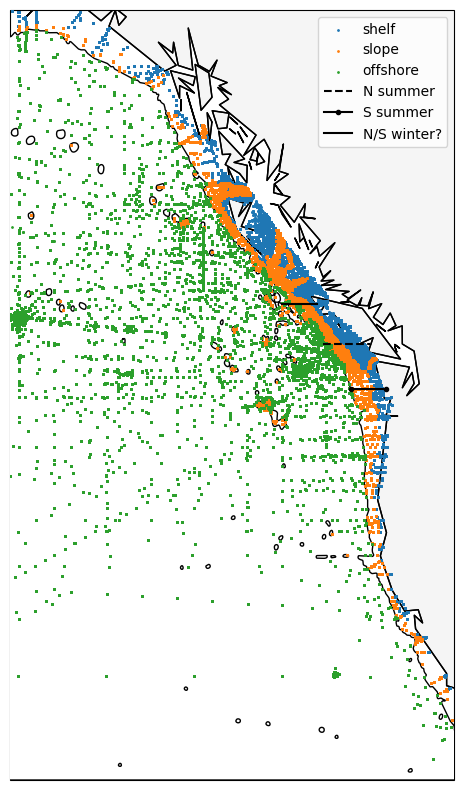

In [14]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()


In [15]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [16]:
# save  obs file with all the data you don't need removed and the location and month columns added
obs.to_csv('./filtered_obs.csv')

In [17]:
obs

,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,Mn (nmol kg-1),Ni (nmol kg-1),Zn (nmol kg-1),Co (nmol kg-1),source,Nstar (umol kg-1),spice,geometry,location,month
0,776,1933-07-24 00:00:00+00:00,-126.60,49.58,3.0,3.278009,NaN,31.884746,NaN,NaN,...,NaN,NaN,NaN,NaN,ios bottle,NaN,NaN,POINT (-126.6 49.58),shelf,7
1,777,1933-07-24 00:00:00+00:00,-126.60,49.58,10.0,10.086320,NaN,32.492994,NaN,NaN,...,NaN,NaN,NaN,NaN,ios bottle,NaN,NaN,POINT (-126.6 49.58),shelf,7
2,778,1933-07-24 00:00:00+00:00,-126.60,49.58,20.0,20.173134,NaN,32.653911,NaN,NaN,...,NaN,NaN,NaN,NaN,ios bottle,NaN,NaN,POINT (-126.6 49.58),shelf,7
3,779,1933-07-24 00:00:00+00:00,-126.60,49.58,30.0,30.260440,NaN,32.804500,NaN,NaN,...,NaN,NaN,NaN,NaN,ios bottle,NaN,NaN,POINT (-126.6 49.58),shelf,7
4,780,1933-07-24 00:00:00+00:00,-126.60,49.58,50.0,50.436540,NaN,32.834604,NaN,NaN,...,NaN,NaN,NaN,NaN,ios bottle,NaN,NaN,POINT (-126.6 49.58),shelf,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738426,3464563,2024-07-10 00:00:00+00:00,-124.96,46.85,0.0,0.000000,14.954735,31.923467,386.967302,NaN,...,NaN,NaN,NaN,NaN,ooi,NaN,-0.123746,POINT (-124.96 46.85),slope,7
1738427,3464564,2024-07-10 00:00:00+00:00,-124.95,44.37,0.0,0.000000,5.939442,34.216526,63.727096,NaN,...,NaN,NaN,NaN,NaN,ooi,NaN,-0.071844,POINT (-124.95 44.37),slope,7
1738428,3464568,2024-07-10 00:00:00+00:00,-124.57,46.99,0.0,0.000000,9.221782,33.383366,55.642270,NaN,...,NaN,NaN,NaN,NaN,ooi,NaN,-0.169475,POINT (-124.57 46.99),shelf,7
1738429,3464569,2024-07-10 00:00:00+00:00,-124.56,46.99,0.0,0.000000,11.482587,32.719748,555.956412,NaN,...,NaN,NaN,NaN,NaN,ooi,NaN,-0.246750,POINT (-124.56 46.99),shelf,7
